In [ ]:
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "STIXGeneral",
    "text.latex.preamble": r"\usepackage[utf8]{inputenc}\usepackage{amsmath}",
    "figure.figsize": [12, 4],  # ancho, Largo  
    "xtick.labelsize": 12,  # tamaño ticks en eje x
    "ytick.labelsize": 12   # tamaño ticks en eje y
})


import time
import pandas as pd
import random
import os                          # Import operating system interface
import win32com.client as win32    # Import COM
from botorch.models import SingleTaskGP, ModelListGP
from botorch.optim import optimize_acqf
from botorch import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood

import torch
import torch.nn as nn
import torch.nn.functional as F

from botorch.models.transforms import Normalize, Standardize
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.acquisition import UpperConfidenceBound, ExpectedImprovement
from botorch.sampling import SobolQMCNormalSampler
from botorch.utils.multi_objective.box_decompositions.non_dominated import (
    FastNondominatedPartitioning)

In [2]:
seed = 42
random.seed(seed) # random seed for Python's random module
np.random.seed(seed) # random seed for NumPy
torch.manual_seed(seed) # random seed for PyTorch

Generar puntos para entrenar el encoder y decoder

In [3]:
def data_encoder_generation(bounds, num_initial_points, categorical_variables = 4,seed = 42):
    """
    :parambounds: Bounds tensor for the variables.
    :param num_initial_points: Number of initial points to generate.
    :param satisfies_constraints: Function that checks if a point satisfies the constraints.
    :return: Results 
    """
    # Deterministic behaviour
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    initial_points = []
    total_points = num_initial_points* categorical_variables
    while len(initial_points) < total_points:
        candidate_point = []
        for i in range(bounds.shape[1]): 
            value = torch.randint(bounds[0, i].to(torch.int).item(), bounds[1, i].to(torch.int).item() + 1, (1,)).item()
            candidate_point.append(value)      
  
        if satisfies_constraints_discrete(candidate_point):
            for k in range(categorical_variables):
                categorical_val = [k]
                discreteset_val = candidate_point
                initial_points.append( categorical_val + discreteset_val)
    return torch.tensor(initial_points, dtype=torch.float64)

def satisfies_constraints_discrete(x):
    Constraint_List = []
    # Extraction column restrictions
    Constraint_List.append(x[0]<x[1])  
    Feasibility = all(Constraint_List) == True  
    return Feasibility
 
bounds = torch.tensor([[1 , 20] ,
                       [60, 60]],dtype = torch.float64)
num_initial_points = 5000
initial_points = data_encoder_generation(bounds , num_initial_points=num_initial_points)
print('Number of points generated:', len(initial_points))
initial_points


Number of points generated: 20000


tensor([[ 0., 17., 28.],
        [ 1., 17., 28.],
        [ 2., 17., 28.],
        ...,
        [ 1.,  8., 55.],
        [ 2.,  8., 55.],
        [ 3.,  8., 55.]], dtype=torch.float64)

In [4]:
columns_to_encode = initial_points
X_discrete_raw = columns_to_encode.clone()  # tamaño (N, 3)
X_discrete_idx = X_discrete_raw.clone().detach()


Define class for variational autoencoder

In [5]:

class VariationalAutoencoder(nn.Module):
    def __init__(self, emb_dim=8,   latent_dim=8):
        super().__init__()
        self.emb_dim = emb_dim
        self.latent_dim = latent_dim
        # Embeddings for each discrete variable
        self.var1_emb = nn.Embedding(4, emb_dim)  
        self.var2_emb = nn.Embedding(60, emb_dim)
        self.var3_emb = nn.Embedding(41, emb_dim) 

        # Encoder y decoder
        self.encoder_fc = nn.Sequential(
            nn.Linear(3 * emb_dim, 16),
            nn.ReLU(),
            # nn.Linear(16, 8)
        )
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 3 * emb_dim)
        )

        # Individual decoders per variable
        self.var1_out = nn.Linear(emb_dim, 4)
        self.var2_out = nn.Linear(emb_dim, 60)
        self.var3_out = nn.Linear(emb_dim, 41)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def recover(self, z_space_predicted):

        y_decoded = self.decoder(z_space_predicted).squeeze(0)
        # Separate the decoder outputs for each variable
        f1_dec, f2_dec, st_dec = torch.chunk(y_decoded, 3, dim=1)
        f1_logits = self.var1_out(f1_dec)
        f2_logits = self.var2_out(f2_dec) 
        st_logits = self.var3_out(st_dec)

        # Apply softmax to obtain probabilities
        f1_probs = F.softmax(f1_logits, dim=1)
        f2_probs = F.softmax(f2_logits, dim=1)
        st_probs = F.softmax(st_logits, dim=1)

        # Adjust indexes
        f1_discrete = torch.argmax(f1_probs, dim=1)  # solvente
        f2_discrete = torch.argmax(f2_probs, dim=1) + 1  # alimentación
        # Mask for st_probs
        mask = torch.arange(41, device=st_probs.device).unsqueeze(0)
        invalid_mask = mask <= (f2_discrete.unsqueeze(1) - 20)
        st_probs[invalid_mask] = 0.0
        st_probs = st_probs / st_probs.sum(dim=1, keepdim=True)
        st_discrete = torch.argmax(st_probs, dim=1) + 20  

        return f1_discrete, f2_discrete, st_discrete

    def forward(self, x):
        # x: batch x 3 (enteros)
        solvent_type, f, nstages = x[:, 0], x[:, 1], x[:, 2]

        # Adjust indexes to 0-based
        solvent_idx = solvent_type 
        f1_idx = f - 1
        stage_idx = nstages - 20

        # Embeddings
        solvent_emb = self.var1_emb(solvent_idx)
        f_emb = self.var2_emb(f1_idx)
        st_emb = self.var3_emb(stage_idx)

        h = torch.cat([solvent_emb, f_emb, st_emb], dim=1)
        h_enc = self.encoder_fc(h)


        mu = self.fc_mu(h_enc)
        logvar = self.fc_logvar(h_enc)
        z = self.reparameterize(mu, logvar)
        
        h_dec = self.decoder(z)

        # Separate representation and decode each variable
        f1_dec, f2_dec, st_dec = torch.chunk(h_dec, 3, dim=1)

        f1_logits = self.var1_out(f1_dec)
        f2_logits = self.var2_out(f2_dec)
        st_logits = self.var3_out(st_dec)

        return f1_logits, f2_logits, st_logits , mu, logvar




Separate data into train and test, as they are randomly generated, shuffle is not necessary.

In [6]:
trainsize = int(len(initial_points)*.70)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VariationalAutoencoder(emb_dim=8,   latent_dim= 8 ).to(device)
checkpoint = torch.load('VAE_LLExtraction.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

VariationalAutoencoder(
  (var1_emb): Embedding(4, 8)
  (var2_emb): Embedding(60, 8)
  (var3_emb): Embedding(41, 8)
  (encoder_fc): Sequential(
    (0): Linear(in_features=24, out_features=16, bias=True)
    (1): ReLU()
  )
  (fc_mu): Linear(in_features=16, out_features=8, bias=True)
  (fc_logvar): Linear(in_features=16, out_features=8, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=24, bias=True)
  )
  (var1_out): Linear(in_features=8, out_features=4, bias=True)
  (var2_out): Linear(in_features=8, out_features=60, bias=True)
  (var3_out): Linear(in_features=8, out_features=41, bias=True)
)

Test if initial data can be reconstructed with accuracy

In [8]:

sample =  X_discrete_raw[0:trainsize].to(dtype=torch.long) 
with torch.no_grad():
    # Adjust indexes for embeddings
    f1_idx = sample[:, 0]
    f2_idx = sample[:, 1] - 1
    st_idx = sample[:, 2] - 20

    # Get embeddings
    f1_emb = model.var1_emb(f1_idx)
    f2_emb = model.var2_emb(f2_idx)
    st_emb = model.var3_emb(st_idx)

    # Concatenate embeddings and pass through the encoder
    h = torch.cat([f1_emb, f2_emb, st_emb], dim=1)
    h_enc = model.encoder_fc(h)
    mu = model.fc_mu(h_enc)
    logvar = model.fc_logvar(h_enc)

    z_train =  model.reparameterize(mu, logvar)
    # Pass z through the decoder
    y_decoded = model.decoder(z_train)

    # Separate the decoder outputs for each variable
    f1_dec, f2_dec, st_dec = torch.chunk(y_decoded, 3, dim=1)
    f1_logits = model.var1_out(f1_dec)
    f2_logits = model.var2_out(f2_dec) 
    st_logits = model.var3_out(st_dec)


    # Apply softmax to obtain probabilities
    f1_probs = F.softmax(f1_logits, dim=1)
    f2_probs = F.softmax(f2_logits, dim=1)
    st_probs = F.softmax(st_logits, dim=1)

    # Adjust indexes
    f1_discrete = torch.argmax(f1_probs, dim=1)  # solvente
    f2_discrete = torch.argmax(f2_probs, dim=1) + 1  # alimentación
    # Mask for st_probs
    mask = torch.arange(41, device=st_probs.device).unsqueeze(0)
    invalid_mask = mask <= (f2_discrete.unsqueeze(1) - 20)
    st_probs[invalid_mask] = 0.0
    st_probs = st_probs / st_probs.sum(dim=1, keepdim=True)
    st_discrete = torch.argmax(st_probs, dim=1) + 20  # etapas

# Combine discrete variables into a tensor
discrete_values = torch.cat([f1_discrete.unsqueeze(1), 
                             f2_discrete.unsqueeze(1), 
                             st_discrete.unsqueeze(1)], dim=1)
print("Discrete values ​​recovered:", discrete_values)


Discrete values ​​recovered: tensor([[ 0, 17, 28],
        [ 1, 17, 28],
        [ 2, 17, 28],
        ...,
        [ 1, 20, 50],
        [ 2, 20, 50],
        [ 3, 20, 50]])


In [9]:
# bounds
min_bounds, max_bounds = [] , []
for i in range(z_train.shape[1]):
    min_bounds.append(z_train[:,i].min().item())
    max_bounds.append(z_train[:,i].max().item())
print('min_bounds',min_bounds)
print('max_bounds',max_bounds)



min_bounds [-3.011702060699463, -2.4719438552856445, -3.002110481262207, -3.1691911220550537, -1.9156956672668457, -4.286701679229736, -1.755281925201416, -3.161806106567383]
max_bounds [2.743227243423462, 3.172558307647705, 2.863468885421753, 3.0122597217559814, 2.8513875007629395, 4.523606300354004, 2.763730049133301, 2.7032835483551025]


### Begin B.O.

Generate points to evaluate with ASPEN, the bounds must correspond to the same as the autoencoder and decoder, otherwise the latent space can be projected with high uncertainty if these are recommended by B.O.

In [10]:

def population_generation(bounds, var_types, num_initial_points,seed = 42):
    """
    :param bounds: Bounds tensor for the variables.
    :param num_initial_points: Number of initial points to generate.
    :param satisfies_constraints: Function that checks whether a point satisfies the constraints.
    :return: Results
    """
    # Deterministic behaviour
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    initial_points_BO = []

    while len(initial_points_BO) < num_initial_points:
        candidate_point = []
        for i in range(len(var_types)): 
            if var_types[i] == 'real':
                value = torch.rand(1).item() * (bounds[1, i] - bounds[0, i]) + bounds[0, i]
            elif var_types[i] == 'int':
                value = torch.randint(bounds[0, i].to(torch.int).item(), bounds[1, i].to(torch.int).item() + 1, (1,)).item()
            candidate_point.append(value)
            
        #candidate_point = torch.tensor(candidate_point)
        if satisfies_constraints(candidate_point):
            initial_points_BO.append(candidate_point)
    return torch.tensor(initial_points_BO, dtype=torch.float64)

# Constrains
def satisfies_constraints(x):
    Constraint_List = []
    Constraint_List.append(x[3]<x[4])
    Feasibility = all(Constraint_List) == True   
    return Feasibility

# Manipulated variables 
#                       Re, S/F, SolventType, F, NT 
bounds = torch.tensor([[0.1, 1.5 , 0 , 1 , 20] ,
                       [3.0, 10.0, 3, 60, 60]],dtype = torch.float64)

var_types = ['real', 'real', 'int', 'int', 'int']

# Get initial points
n_iterations = 1000
num_initial_points = 10
initial_points_BO = population_generation(bounds, var_types , num_initial_points=num_initial_points)
print('Number of points generated:', len(initial_points_BO))
# initial_points_BO

Number of points generated: 10


In [11]:
# Discrete variables, format must be changed to long or int type
continuos_initial_points = initial_points_BO[:, 0:2].numpy()
discrete_initial_points = torch.tensor(np.array(initial_points_BO[:, 2:]),dtype=torch.long)

with torch.no_grad():
    # Adjust indexes for embeddings
    f1_idx = discrete_initial_points[:, 0] 
    f2_idx = discrete_initial_points[:, 1] - 1
    st_idx = discrete_initial_points[:, 2] - 20

    # Get embeddings
    f1_emb = model.var1_emb(f1_idx)
    f2_emb = model.var2_emb(f2_idx)
    st_emb = model.var3_emb(st_idx)

    # Concatenate embeddings and pass through the encoder
    h = torch.cat([f1_emb, f2_emb, st_emb], dim=1)
    h_enc = model.encoder_fc(h)

    mu = model.fc_mu(h_enc)
    logvar = model.fc_logvar(h_enc)
    z_new =  model.reparameterize(mu, logvar)
# Concatenate continuous variables with new latent space
converted_points = torch.tensor(np.hstack( (continuos_initial_points, z_new))  )

In [12]:

class AspenSimulation:
    
    def __init__(self, aspen_file_path1, aspen_file_path2):
        """
        Initializes the connection to ASPEN and sets the paths for variables and outputs.

        :param aspen_file_path: Path to the ASPEN file.
        :param variable_nodes: List of paths for variables in ASPEN.
        :param output_nodes: List of paths for outputs in ASPEN.
        """
        self.aspen_file_path1 = os.path.abspath(aspen_file_path1)
        self.aspen1 = None

        self.aspen_file_path2 = os.path.abspath(aspen_file_path2)
        self.aspen2 = None

    def connect(self):
        import win32com.client as win32 
        """Connect to ASPEN and load the first simulation"""
        self.aspen1 = win32.Dispatch("Apwn.Document") # .client.Dispatch("Apwn.Document")
        self.aspen1.InitFromFile(self.aspen_file_path1)
        self.aspen1.Visible  = False
        self.aspen1.SuppressDialogs = True
        time.sleep(3)
        self.aspen1.Engine.Run2()
        time.sleep(3)
        """Connect to ASPEN and load the second simulation"""
        self.aspen2 = win32.Dispatch("Apwn.Document") # .client.Dispatch("Apwn.Document")
        self.aspen2.InitFromFile(self.aspen_file_path2)
        self.aspen2.Visible  = False
        self.aspen2.SuppressDialogs = True
        time.sleep(1.1)
        self.aspen2.Engine.Run2()
        time.sleep(1.1)

    def Error_Run(self):
        return [0.0001] #  

    def Clean_Aspen(self):
        x = [85,2]
        #-----------------------------Column 1-----------------------------#
        N_C1 = r"\Data\Blocks\D1\Input\NSTAGE"
        FeedStage  = r"\Data\Blocks\D1\Input\FEED_STAGE\S1"  
        #Send to Aspen #
        self.aspen1.Tree.FindNode(N_C1).Value = x[0] 
        self.aspen1.Tree.FindNode(FeedStage).Value = x[1]   
        #Send to Aspen #
        self.aspen2.Tree.FindNode(N_C1).Value = x[0] 
        self.aspen2.Tree.FindNode(FeedStage).Value = x[1]   

    def Update_Aspen(self,x):
        #-----------------------------Column 1-----------------------------#
        N_C1 = r"\Data\Blocks\D1\Input\NSTAGE"
        RR_C1  = r"\Data\Blocks\D1\Input\BASIS_RR"
        solvent_flow_rate = r"\Data\Streams\SOLVENT\Input\TOTFLOW\MIXED"
        FeedStage  = r"\Data\Blocks\D1\Input\FEED_STAGE\S1"  
        #Send to Aspen #
        if x[2] == 0:
            self.aspen1.Tree.FindNode(N_C1).Value = x[4] 
            self.aspen1.Tree.FindNode(RR_C1).Value = x[0] 
            self.aspen1.Tree.FindNode(solvent_flow_rate).Value = x[1] 
            self.aspen1.Tree.FindNode(FeedStage).Value = x[3] 
        else:
            self.aspen2.Tree.FindNode(N_C1).Value = x[4] 
            self.aspen2.Tree.FindNode(RR_C1).Value = x[0] 
            self.aspen2.Tree.FindNode(solvent_flow_rate).Value = x[1] 
            self.aspen2.Tree.FindNode(FeedStage).Value = x[3] 
            if x[2] == 1:
                self.aspen2.Tree.FindNode(r"\Data\Streams\SOLVENT\Input\FLOW\MIXED\1-DEC-01").Value = 1
                self.aspen2.Tree.FindNode(r"\Data\Streams\SOLVENT\Input\FLOW\MIXED\1-OCT-01").Value = 0
                self.aspen2.Tree.FindNode(r"\Data\Streams\SOLVENT\Input\FLOW\MIXED\N-BUT-01").Value = 0
            elif x[2] == 2:
                self.aspen2.Tree.FindNode(r"\Data\Streams\SOLVENT\Input\FLOW\MIXED\1-DEC-01").Value = 0
                self.aspen2.Tree.FindNode(r"\Data\Streams\SOLVENT\Input\FLOW\MIXED\1-OCT-01").Value = 1
                self.aspen2.Tree.FindNode(r"\Data\Streams\SOLVENT\Input\FLOW\MIXED\N-BUT-01").Value = 0
            elif x[2] == 3:
                self.aspen2.Tree.FindNode(r"\Data\Streams\SOLVENT\Input\FLOW\MIXED\1-DEC-01").Value = 0
                self.aspen2.Tree.FindNode(r"\Data\Streams\SOLVENT\Input\FLOW\MIXED\1-OCT-01").Value = 0
                self.aspen2.Tree.FindNode(r"\Data\Streams\SOLVENT\Input\FLOW\MIXED\N-BUT-01").Value = 1

    def Feasibily_Check(self,x):
        Constraint_List = []
        Constraint_List.append(x[3]<x[4])  
        Feasibility = all(Constraint_List) == True   
        return Feasibility

    def run_simulation(self, variables):
        """
        Runs the simulation in ASPEN with the values ​​of the provided variables.
        :param variables: List or array of values ​​for the variables.
        :return: Array of output results.
        """
        self.aspen1.Reinit()
        self.aspen2.Reinit()
        # Before running Aspen evaluate if the point is feasible
        if self.Feasibily_Check(variables) == False:
            print("Unfeasible point tested, point is penalized")
            results =  self.Error_Run() 
            return results 
        Run_Status_Dir = r"\Data\Results Summary\Run-Status\Output\UOSSTAT2"
        results = []  # List to save ressult
        if variables[2] == 0:  # Solvent one is tested (first simulation)
            if self.aspen1 is None:
                raise RuntimeError("ASPEN is not connected. Call connect() before running a simulation.")
            
            # Clean Aspen with default values
            self.Clean_Aspen()

            # Assigns the values ​​of the variables in ASPEN
            self.Update_Aspen(variables)

            # Run the simulation
            self.aspen1.Engine.Run2()

            if self.aspen1.Tree.FindNode(Run_Status_Dir) == None:
                results =  self.Error_Run()  
            else:
                Run_Status = self.aspen1.Tree.FindNode(Run_Status_Dir).Value
                if Run_Status == 9 or Run_Status == 10:
                    results =  self.Error_Run() 
                    self.aspen1.Reinit()
                else:
                    # Pureza
                    pureza = self.aspen1.Tree.FindNode(r"\Data\Streams\PRODUCT\Output\MOLEFRAC\MIXED\CAPRYC").Value
                    results.append(pureza)


                    # REBOILER  B1 #
                    # REB_DUTY_D1 = r"\Data\Blocks\D1\Output\REB_DUTY"
                    # ReboilerDuty = self.aspen1.Tree.FindNode(REB_DUTY_D1).Value*0.0041868    #cal/sec to kW
                    #results.append(-1*ReboilerDuty)
                    self.aspen1.Reinit()
        else:  # Other solvent
            if self.aspen2 is None:
                raise RuntimeError("ASPEN is not connected. Call connect() before running a simulation.")
            # Clean Aspen 
            self.Clean_Aspen()
            # Update Aspen
            self.Update_Aspen(variables)
            # Run simulation
            self.aspen2.Engine.Run2()

            if self.aspen2.Tree.FindNode(Run_Status_Dir) == None:
                results =  self.Error_Run()  
            else:
                Run_Status = self.aspen2.Tree.FindNode(Run_Status_Dir).Value
                if Run_Status == 9 or Run_Status == 10:
                    results =  self.Error_Run() 
                    self.aspen2.Reinit()
                else:
                    # PUREZa
                    pureza = self.aspen2.Tree.FindNode(r"\Data\Streams\PRODUCT\Output\MOLEFRAC\MIXED\CAPRYC").Value
                    # results.append(np.log(pureza))
                    results.append(pureza)

                    # REBOILER  B1 #
                    REB_DUTY_D1 = r"\Data\Blocks\D1\Output\REB_DUTY"
                    ReboilerDuty = self.aspen2.Tree.FindNode(REB_DUTY_D1).Value*0.0041868    #cal/sec to kW
                    #results.append(-1*ReboilerDuty)
                    self.aspen2.Reinit()

        return results

    def close(self):
        """Close the connection to ASPEN."""
        if self.aspen1 is not None:
            self.aspen1.Close()
            self.aspen1 = None
        if self.aspen2 is not None:
            self.aspen2.Close()
            self.aspen2 = None


In [13]:
Application = AspenSimulation(aspen_file_path1= "CaprylicAcid_ST1.bkp" , aspen_file_path2 = "CaprylicAcid_ST2.bkp" )
Application.connect()
initial_evals = torch.tensor(np.array([Application.run_simulation(point) for point in initial_points_BO]), dtype=torch.float64)
print(initial_evals.shape)
print('Max function value:', initial_evals[:,0].max().item())
print('Min function value:', initial_evals[:,0].min().item())
Application.close()

torch.Size([10, 1])
Max function value: 0.952380951
Min function value: 0.118791711


In [14]:

class SingleObjectiveBayesianOpt:
    """
    A method for single-objective optimization problems.

    This class find optimal solutions when a single objectives exist. It automatically handles:
    - Gaussian Process model training for each objective
    - Selection of uncertain points for iterative improvement
    - Multiple optimization iterations with automatic data augmentation

    Attributes:
        X_init (torch tensor): Initial decision variable values (unscaled)
        Y_init (torch tensor): Initial objective function values (unscaled)
        var_names (list): Names of decision variables
        obj_names (list): Names of objective functions
        n_iterations (int): Number of optimization iterations
        grid_points (int): Number of points in prediction grid
        X_ranges (dict): Ranges for each decision variable
        X_scaled (np.array): Scaled decision variables (-1 to 1)
        X_real (np.array): Unscaled decision variables
        Y (np.array): Objective function values
        gpr_models (list): Trained Gaussian Process models
        history (list): Optimization history
        predictions (np.array): Grid predictions
        std_devs (np.array): Prediction standard deviations
    """

    def __init__(self, X_init, Y_init,  bounds, model_enddec, 
                 obj_names, latent_dim, n_evals, method, Aspen_Application):
        """
        Args:
            X_init (tensor): Initial decision variable values (unscaled)
            Y_init (tensor): Initial objective function values (unscaled)
            obj_names (list): Names of objective functions
            latent_dim (int): Dimention of the latent space
            n_evals (int): Number of evaluations that will be run 
            method (str): Define which method will be used, it can be 
            specified as upc, ei
        """

        # Initialize Aspen
        self.Aspen_Application = Aspen_Application
        self.Aspen_Application.connect()

        # Additional variables 
        self.n_evals = n_evals
        self.X_init = X_init
        self.all_points = X_init
        self.Y_init = Y_init
        self.all_objectives = Y_init

        self.obj_names = obj_names
        self.bounds = bounds
        self.model_enddec = model_enddec
        self.latent_dim = latent_dim

        # Training data
        self.method = method
        # Prediction results
        self.predictions = None
        self.std_devs = None

    def train_gpr_model(self, X, Y ):
        """Train independent Gaussian Process models for each objective function."""
        self.gp_models = []
        for i in range(Y.shape[1]):
            gp = SingleTaskGP(X, Y[:,i].unsqueeze(1) , 
                                input_transform=Normalize(d=10),
                                outcome_transform=Standardize(m=1))
            self.gp_models.append(gp)
        self.mlls = [ExactMarginalLogLikelihood(m.likelihood, m) for m in self.gp_models]
        for mll in self.mlls:
            fit_gpytorch_mll(mll)

    def prediction_grid_std(self , acqfs,  batch_size = 1000,  n_samples = 200, ktop = 10):
        """
        Evalute the aqcs with the bounds.
        Return: Best points
        """
        n_samples = 5000
        n_dims = bounds.shape[1] 

        # Sample uniform random points in each dimension of the bounds
        random_samples = torch.rand(n_samples, n_dims, dtype=torch.float64)
        lower_bounds = bounds[0]
        upper_bounds = bounds[1]
        scaled_samples = lower_bounds + (upper_bounds - lower_bounds) * random_samples
        self.final_points =  scaled_samples 
        final_points_batched = self.final_points

        batch_size = 100
        acq_values_list = []
        all_indices = []
        offset = 0
        with torch.no_grad():
            for acqf in acqfs:
                local_acq_values  = []
                for i in range(0, final_points_batched.shape[0], batch_size):
                    batch = final_points_batched[i:i + batch_size]  # slice batch
                    acq_vals = acqf(batch.unsqueeze(1))
                    local_acq_values.append(acq_vals)

                # Save values ​​for each pothole for each aqf
                local_acq_values = torch.cat(local_acq_values, dim=0)
                # Save the values ​​in a global list
                acq_values_list.append(local_acq_values)


                # Save all indexes for each aqf
                indices = torch.arange(final_points_batched.shape[0], dtype=torch.long) + offset
                all_indices.append( indices)
                # Update offset to keep indexes different
                offset += final_points_batched.shape[0]
        
        acq_values = torch.cat(acq_values_list, dim=0)
        total_indices = torch.cat(all_indices, dim=0)
        
        #  Get top K candidates by acquisition
        topk_vals, topk_indices = torch.topk(acq_values.squeeze(-1), k=ktop)
        topk_final_indices = total_indices[topk_indices]
        # Get the best points according to the aqf to test with GPS
        final_points_expanded = final_points_batched.repeat(len(acqfs), 1)
        topk_candidates = final_points_batched[topk_final_indices]

        return  topk_candidates


    def converted_candidates(self):
        # Pass z through the decoder
        z_space_predicted = torch.tensor([self.all_points[:, -self.latent_dim:].numpy()] , dtype=torch.float32)
        f1_discrete, f2_discrete, st_discrete = self.model_enddec.recover(z_space_predicted)
        
        return torch.cat((self.all_points[:,:2], f1_discrete.unsqueeze(1), f2_discrete.unsqueeze(1), st_discrete.unsqueeze(1)), dim=1).numpy()

    def run_optimization(self):
        """
        Run the complete optimization process for all iterations.

        """
        # Listas para salvar datos
        self.latent_space_BO = []
        self.tracking_OF = []
        self.utopia_distance = []
        self.all_points, self.all_objectives = self.X_init, self.Y_init
        number_eval = self.X_init.shape[0]

        print('Start optimization process')
        while number_eval < self.n_evals:
            if self.method == 'UCB':
                self.train_gpr_model(self.all_points, self.all_objectives)
                UpperConfidenceBound_acquisitions = [UpperConfidenceBound(gp, beta=0.1) for gp in self.gp_models]
                best_candidates = self.prediction_grid_std(UpperConfidenceBound_acquisitions)
                optimal_candidates = best_candidates
                
                # Pass z through the decoder
                z_space_predicted = torch.tensor(optimal_candidates[:, 2:].numpy(), dtype=torch.float32).unsqueeze(0)
                self.latent_space_BO.append(z_space_predicted)

                f1_discrete, f2_discrete, st_discrete = self.model_enddec.recover(z_space_predicted)

                new_candidates  = torch.cat((optimal_candidates[:,0:2], f1_discrete.unsqueeze(1), 
                                            f2_discrete.unsqueeze(1), st_discrete.unsqueeze(1)), dim=1).numpy()

                new_eval  = torch.tensor(np.array([self.Aspen_Application.run_simulation(point) for point in new_candidates]), dtype=torch.float64)

                # Update data collected by the GP

                self.all_points = torch.cat([self.all_points, optimal_candidates ], dim = 0 )  
                self.all_objectives = torch.cat([self.all_objectives, new_eval], dim = 0  ) 

                self.tracking_OF.append(self.all_objectives.max().item())
                number_eval = self.all_points.shape[0]
                print('number of functions evaluations:', number_eval)
            elif self.method == 'EI':
                self.train_gpr_model(self.all_points, self.all_objectives)
                ExpectedImprovement_acquisitions  = [ExpectedImprovement(gp,best_f = self.all_objectives.max().item()  ) for i, gp in enumerate(self.gp_models)]
                best_candidates = self.prediction_grid_std(ExpectedImprovement_acquisitions)
                optimal_candidates = best_candidates

                # Pass z through the decoder
                z_space_predicted = torch.tensor(optimal_candidates[:, 2:].numpy(), dtype=torch.float32).unsqueeze(0)
                self.latent_space_BO.append(z_space_predicted)

                f1_discrete, f2_discrete, st_discrete = self.model_enddec.recover(z_space_predicted)

                new_candidates  = torch.cat((optimal_candidates[:,0:2], f1_discrete.unsqueeze(1), 
                                            f2_discrete.unsqueeze(1), st_discrete.unsqueeze(1)), dim=1).numpy()

                new_eval  = torch.tensor(np.array([self.Aspen_Application.run_simulation(point) for point in new_candidates]), dtype=torch.float64)

                # Update data collected by the GP


                self.all_points = torch.cat([self.all_points, optimal_candidates ], dim = 0 )  
                self.all_objectives = torch.cat([self.all_objectives, new_eval], dim = 0  ) 

                self.tracking_OF.append(self.all_objectives.max().item())
                number_eval = self.all_points.shape[0]
                print('number of functions evaluations:', number_eval)
        # Close Aspen :D 
        self.Aspen_Application.close()

    def save_data(self, file = r'test.csv'):
        # Funciones objetivos
        df1 = pd.DataFrame(data=self.all_objectives.numpy() , columns=self.obj_names)
        data_names = [ 'x'+ str(i+1)  for i in range(self.converted_candidates().shape[1])]
        # Datos iniciales usados para entrenar GP  
        df2 = pd.DataFrame(data=self.converted_candidates() , columns= data_names)
        
        
        # Get initial latent space in X_train
        initial_z_space = self.X_init[:, -self.latent_dim:].numpy()
        # Get new latent space explored
        latent_space_BOs = self.latent_space_BO
        latent_BO_matrix = torch.cat(latent_space_BOs, dim=1).numpy().squeeze(0)
        total_latent = np.concatenate((initial_z_space,latent_BO_matrix),axis = 0)
        space_names =  [ 'z'+ str(i+1)  for i in range(total_latent.shape[1])]
        df3 = pd.DataFrame(data= total_latent, columns =space_names )
        df = pd.concat([df1,df2,df3], axis= 1)
        df = df.drop_duplicates()
        df.to_csv(file, index=False)  


In [15]:

class SingleObjectiveBayesianOpt:
    """
    A method for single-objective optimization problems.

    This class find optimal solutions when a single objectives exist. It automatically handles:
    - Gaussian Process model training for each objective
    - Selection of uncertain points for iterative improvement
    - Multiple optimization iterations with automatic data augmentation

    Attributes:
        X_init (torch.Tensor): Initial decision variable values (unscaled).
        Y_init (torch.Tensor): Initial objective function values (unscaled).
        bounds (torch.Tensor): Lower and upper bounds for each decision variable (shape: [2, d]).
        model_enddec (object): Decoder/encoder model used to recover discrete variables from latent space.
        obj_names (list of str): Names of objective functions.
        latent_dim (int): Dimension of the latent space used by the decoder.
        n_evals (int): Maximum number of function evaluations allowed during optimization.
        method (str): Acquisition method to be used ('UCB', 'EI', etc.).
        Aspen_Application (object): External Aspen simulation application interface.

        all_points (torch.Tensor): Collection of all decision variable points sampled so far.
        all_objectives (torch.Tensor): Collection of all objective values evaluated so far.
        gp_models (list): Trained Gaussian Process models, one per objective.
        mlls (list): Marginal log-likelihoods used to fit each GP model.
        latent_space_BO (list): Sequence of latent points selected across iterations.
        tracking_OF (list): Best objective values tracked during optimization.
        utopia_distance (list): Distances to utopia point (if calculated).

        predictions (torch.Tensor or None): GP predictions on candidate points (if evaluated).
        std_devs (torch.Tensor or None): Standard deviations of GP predictions (if evaluated).
        final_points (torch.Tensor or None): Candidate points sampled during acquisition evaluation.
    """


    def __init__(
        self,
        X_init: torch.Tensor,
        Y_init: torch.Tensor,
        bounds: torch.Tensor,
        model_enddec,
        obj_names: List[str],
        latent_dim: int,
        n_evals: int,
        method: str,
        Aspen_Application,
    ):
        """
        Args:
            X_init (tensor): Initial decision variable values (unscaled)
            Y_init (tensor): Initial objective function values (unscaled)
            obj_names (list): Names of objective functions
            latent_dim (int): Dimention of the latent space
            n_evals (int): Number of evaluations that will be run 
            method (str): Define which method will be used, it can be 
            specified as std, upc, ei, and qEVH
        """

        # Initialize Aspen
        self.Aspen_Application = Aspen_Application
        self.Aspen_Application.connect()

        # Additional variables 
        self.n_evals = int(n_evals)
        self.X_init = X_init
        self.all_points = X_init
        self.Y_init = Y_init
        self.all_objectives = Y_init

        self.obj_names = obj_names
        self.bounds = bounds  # shape: (2, D)
        self.model_enddec = model_enddec
        self.latent_dim = int(latent_dim)

        # Training data
        self.method = method.upper()  # normalize to uppercase: 'UCB', 'EI', etc.

        # Prediction results
        self.predictions: Optional[torch.Tensor] = None
        self.std_devs: Optional[torch.Tensor] = None

        # Holders initialized later
        self.gp_models: List[SingleTaskGP] = []
        self.mlls: List[ExactMarginalLogLikelihood] = []
        self.latent_space_BO: List[torch.Tensor] = []
        self.tracking_OF: List[float] = []
        self.utopia_distance: List[float] = []

        # Will be set by prediction_grid_std
        self.final_points: Optional[torch.Tensor] = None

    def train_gpr_model(self, X: torch.Tensor, Y: torch.Tensor) -> None:
        """Train independent Gaussian Process models for each objective function."""
        self.gp_models = []
        input_dim = X.shape[1]
        for i in range(Y.shape[1]):
            gp = SingleTaskGP(
                X,
                Y[:, i].unsqueeze(1),
                input_transform=Normalize(d=input_dim),
                outcome_transform=Standardize(m=1),
            )
            self.gp_models.append(gp)
        self.mlls = [ExactMarginalLogLikelihood(m.likelihood, m) for m in self.gp_models]
        for mll in self.mlls:
            fit_gpytorch_mll(mll)

    def prediction_grid_std(
        self,
        acqfs: List,
        batch_size: int = 1000,
        n_samples: int = 5000,
        ktop: int = 10,
    ) -> torch.Tensor:
        """
        Evalute the aqcs with the bounds.
        Return: Best points
        """
        # --- Generate a uniform random grid within bounds
        n_dims = self.bounds.shape[1]
        random_samples = torch.rand(n_samples, n_dims, dtype=torch.float64)
        lower_bounds = self.bounds[0]
        upper_bounds = self.bounds[1]
        scaled_samples = lower_bounds + (upper_bounds - lower_bounds) * random_samples
        self.final_points = scaled_samples  # (n_samples, n_dims)
        final_points_batched = self.final_points

        # --- Evaluate each acquisition on the same grid
        acq_values_list = []
        with torch.no_grad():
            for acqf in acqfs:
                local_vals = []
                for i in range(0, final_points_batched.shape[0], batch_size):
                    batch = final_points_batched[i : i + batch_size]  # slice batch
                    # Many BoTorch acqf expect input shape (batch q d); we use q=1:
                    acq_vals = acqf(batch.unsqueeze(1))
                    local_vals.append(acq_vals)
                local_vals = torch.cat(local_vals, dim=0)  # (n_samples, 1)
                acq_values_list.append(local_vals)

        # --- Stack acquisitions and mirror candidates accordingly
        # Repeat the candidate grid once per acquisition so indexing aligns
        final_points_expanded = final_points_batched.repeat(len(acqfs), 1)  # (A*n_samples, d)
        acq_values = torch.cat(acq_values_list, dim=0).squeeze(-1)          # (A*n_samples,)

        # --- Top-k global selection among all acquisitions
        topk_vals, topk_indices = torch.topk(acq_values, k=ktop)
        topk_candidates = final_points_expanded[topk_indices]

        return topk_candidates

    def converted_candidates(self) -> np.ndarray:
        # Pass z through the decoder
        z_space_predicted = torch.tensor(
            [self.all_points[:, -self.latent_dim :].detach().cpu().numpy()],
            dtype=torch.float32,
        )
        f1_discrete, f2_discrete, st_discrete = self.model_enddec.recover(z_space_predicted)
        
        return torch.cat(
            (
                self.all_points[:, :2],
                f1_discrete.unsqueeze(1).to(dtype=torch.float64),
                f2_discrete.unsqueeze(1).to(dtype=torch.float64),
                st_discrete.unsqueeze(1).to(dtype=torch.float64),
            ),
            dim=1,
        ).detach().cpu().numpy()

    def run_optimization(self) -> None:
        """
        Run the complete optimization process for all iterations.

        Args:
            maximize (list of bool): List indicating whether each objective should be maximized
            n_points_per_iter (int): Number of points to select in each iteration
            objective_function (callable): Function to calculate Y values from X (optional)
                                          If provided, will be used to calculate new Y values
        """
        # Listas para salvar datos
        self.latent_space_BO = []
        self.tracking_OF = []
        self.utopia_distance = []
        self.all_points, self.all_objectives = self.X_init, self.Y_init
        number_eval = self.X_init.shape[0]

        print('Start optimization process')
        while number_eval < self.n_evals:
            if self.method == 'UCB':
                self.train_gpr_model(self.all_points, self.all_objectives)
                UpperConfidenceBound_acquisitions = [UpperConfidenceBound(gp, beta=0.1) for gp in self.gp_models]
                best_candidates = self.prediction_grid_std(UpperConfidenceBound_acquisitions)
                optimal_candidates = best_candidates
                
                # Pass z through the decoder
                z_space_predicted = torch.tensor(
                    optimal_candidates[:, 2:].detach().cpu().numpy(), dtype=torch.float32
                ).unsqueeze(0)
                self.latent_space_BO.append(z_space_predicted)

                f1_discrete, f2_discrete, st_discrete = self.model_enddec.recover(z_space_predicted)

                new_candidates = torch.cat(
                    (
                        optimal_candidates[:, 0:2],
                        f1_discrete.unsqueeze(1).to(dtype=torch.float64),
                        f2_discrete.unsqueeze(1).to(dtype=torch.float64),
                        st_discrete.unsqueeze(1).to(dtype=torch.float64),
                    ),
                    dim=1,
                ).detach().cpu().numpy()

                new_eval = torch.tensor(
                    np.array([self.Aspen_Application.run_simulation(point) for point in new_candidates]),
                    dtype=torch.float64,
                )

                # Update data collected by the GP

                self.all_points = torch.cat([self.all_points, optimal_candidates ], dim = 0 )  
                self.all_objectives = torch.cat([self.all_objectives, new_eval], dim = 0  ) 

                self.tracking_OF.append(self.all_objectives.max().item())
                number_eval = self.all_points.shape[0]
                print('number of functions evaluations:', number_eval)

            elif self.method == 'EI':
                self.train_gpr_model(self.all_points, self.all_objectives)
                ExpectedImprovement_acquisitions = [
                    ExpectedImprovement(gp, best_f=self.all_objectives.max().item()) for gp in self.gp_models
                ]
                best_candidates = self.prediction_grid_std(ExpectedImprovement_acquisitions)
                optimal_candidates = best_candidates

                # Pass z through the decoder
                z_space_predicted = torch.tensor(
                    optimal_candidates[:, 2:].detach().cpu().numpy(), dtype=torch.float32
                ).unsqueeze(0)
                self.latent_space_BO.append(z_space_predicted)

                f1_discrete, f2_discrete, st_discrete = self.model_enddec.recover(z_space_predicted)

                new_candidates = torch.cat(
                    (
                        optimal_candidates[:, 0:2],
                        f1_discrete.unsqueeze(1).to(dtype=torch.float64),
                        f2_discrete.unsqueeze(1).to(dtype=torch.float64),
                        st_discrete.unsqueeze(1).to(dtype=torch.float64),
                    ),
                    dim=1,
                ).detach().cpu().numpy()

                new_eval = torch.tensor(
                    np.array([self.Aspen_Application.run_simulation(point) for point in new_candidates]),
                    dtype=torch.float64,
                )

                # Update data collected by the GP

                self.all_points = torch.cat([self.all_points, optimal_candidates ], dim = 0 )  
                self.all_objectives = torch.cat([self.all_objectives, new_eval], dim = 0  ) 

                self.tracking_OF.append(self.all_objectives.max().item())
                number_eval = self.all_points.shape[0]
                print('number of functions evaluations:', number_eval)

        # Close Aspen :D 
        self.Aspen_Application.close()

    def save_data(self, file: str = r'test.csv') -> None:
        # Funciones objetivos
        df1 = pd.DataFrame(data=self.all_objectives.detach().cpu().numpy(), columns=self.obj_names)
        data_names = [ 'x'+ str(i+1)  for i in range(self.converted_candidates().shape[1])]
        # Datos iniciales usados para entrenar GP  
        df2 = pd.DataFrame(data=self.converted_candidates(), columns=data_names)
        
        # Get initial latent space in X_train
        initial_z_space = self.X_init[:, -self.latent_dim:].detach().cpu().numpy()
        # Get new latent space explored
        latent_space_BOs = self.latent_space_BO
        if len(latent_space_BOs) > 0:
            latent_BO_matrix = torch.cat(latent_space_BOs, dim=1).detach().cpu().numpy().squeeze(0)
            total_latent = np.concatenate((initial_z_space, latent_BO_matrix), axis=0)
        else:
            total_latent = initial_z_space
        space_names =  [ 'z'+ str(i+1)  for i in range(total_latent.shape[1])]
        df3 = pd.DataFrame(data= total_latent, columns =space_names )
        df = pd.concat([df1, df2, df3], axis= 1)
        df = df.drop_duplicates()
        df.to_csv(file, index=False)


Single objective procedure -  B.O

In [16]:
bounds = torch.tensor([[0.1, 0.5, min_bounds[0] , min_bounds[1] , min_bounds[2], min_bounds[3], min_bounds[4], min_bounds[5], min_bounds[6], min_bounds[7]] ,
                       [3.0, 10 , max_bounds[0], max_bounds[1] , max_bounds[2], max_bounds[3], max_bounds[4], max_bounds[5], max_bounds[6], max_bounds[7] ]],dtype = torch.float64)

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
latent_dim = 8
model = VariationalAutoencoder(emb_dim=8,   latent_dim= latent_dim ).to(device)
checkpoint = torch.load('VAE_LLExtraction.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Create instance for Aspen
Application = AspenSimulation(aspen_file_path1= "CaprylicAcid_ST1.bkp" , aspen_file_path2 = "CaprylicAcid_ST2.bkp" )


all_points = converted_points
all_objectives = initial_evals
obj_names = ['pureza']
z_train = z_train
n_evals = 20 # Number of evaluations (Stopping criteria)
bounds = torch.tensor([[0.1, 0.5, min_bounds[0] , min_bounds[1] , min_bounds[2], min_bounds[3], min_bounds[4], min_bounds[5], min_bounds[6], min_bounds[7]] ,
                       [3.0, 10 , max_bounds[0], max_bounds[1] , max_bounds[2], max_bounds[3], max_bounds[4], max_bounds[5], max_bounds[6], max_bounds[7] ]],dtype = torch.float64)
MOBO= SingleObjectiveBayesianOpt( X_init = all_points , Y_init = initial_evals,
                        bounds = bounds,  model_enddec = model,  
                        obj_names = obj_names , latent_dim = latent_dim,
                        n_evals = n_evals, method='EI', Aspen_Application = Application ) 
                        # n_evals = n_evals, method='UCB', Aspen_Application = Application )  # other option 

MOBO.run_optimization()  

Start optimization process
number of functions evaluations: 20


In [ ]:
# MOBO.Aspen_Application.close()  # Just in case something goes wrong

In [ ]:
final_points = MOBO.final_points 
final_points_batched = final_points
batch_size = 100

points_gps = []
points_std = []
with torch.no_grad():
    for gp in MOBO.gp_models:
        local_mean_values  = []
        local_std_values = []
        for i in range(0, final_points_batched.shape[0], batch_size):
            batch = final_points_batched[i:i + batch_size]  # slice batch


            prediction = gp.posterior(batch) #batch.unsqueeze(-1))
            local_mean_values.append(prediction.mean)
            local_std_values.append(prediction.stddev.unsqueeze(1))
        local_mean_values = torch.cat(local_mean_values, dim=0)
        local_std_values = torch.cat(local_std_values, dim=0)
        points_gps.append(local_mean_values)
        points_std.append(local_std_values)

all_means = torch.cat(points_gps, dim=1).squeeze(-1)
all_std = torch.cat(points_std, dim=1).squeeze(-1)         

In [ ]:
last_points = final_points[:,-8:] 
last_means = all_means  
last_stds = all_std      

In [ ]:
from sklearn.manifold import TSNE

# Convertir a numpy para TSNE
X = last_points.cpu().numpy()
# t-SNE para 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
X_reduced = tsne.fit_transform(X)  # Shape (8, 2)
x = X_reduced[:, 0]
y = X_reduced[:, 1]
z_pureza = last_means.cpu().numpy()
z_std = last_stds.cpu().numpy()

In [ ]:
from scipy.interpolate import griddata
# Create grid to interpolate
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]
# Linear interpolation (for mask)
grid_linear = griddata((x, y), z_pureza, (grid_x, grid_y),
                        method='linear', fill_value=np.nan, rescale=True)

# Interpolation with nearest (for values)
grid_nearest = griddata((x, y), z_pureza, (grid_x, grid_y),
                         method='nearest', fill_value=np.nan, rescale=True)

# Apply mask: where linear is NaN, set NaN to nearest
mask = np.isnan(grid_linear)
grid_combined = np.where(mask, np.nan, grid_nearest)
grid_combined[grid_combined[:,:] > 0.952380955] = 0.952380955

In [24]:
min_val = np.nanmin(grid_combined)
max_val = np.nanmax(grid_combined)
print(f"Min: {min_val}, Max: {max_val}")

Min: 0.746870836100349, Max: 0.8382580253806485


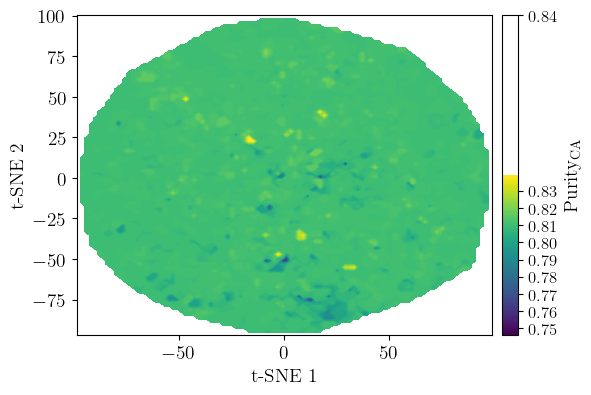

In [26]:
fig = plt.figure(figsize=(6, 4))

# Superficie 3D
# Contour 2D
ax2 = fig.add_subplot(111)
contour = ax2.contourf(grid_x, grid_y, grid_combined, levels=100, cmap='viridis', alpha = 1.0,
                       vmin= np.nanmin(grid_combined) , vmax= np.nanmax(grid_combined))
# ax2.scatter(x, y, c='yellow', edgecolors='black', s=40)  # puntos originales
ax2.set_xlabel('t-SNE 1', fontsize= 14)
ax2.set_ylabel('t-SNE 2', fontsize= 14)
# ax2.set_title('Proyección 2D')
cbar = fig.colorbar(contour, ax=ax2, shrink=1.0, pad=0.02)
cbar.set_ticks(np.round(np.linspace(max_val, min_val, 10),2))
cbar.set_label(label = r'Purity$_{\mathrm{CA}}$', fontsize=14, labelpad=5)
cbar.ax.tick_params(labelsize=12) 
ax2.yaxis.set_tick_params(labelsize=14)
ax2.xaxis.set_tick_params(labelsize=14)
# ax2.yaxis.set_ticklabels([-140,-100, -50,0,50,140])
plt.tight_layout()
plt.show()
fig.savefig('CASE1_PURITY.eps', format = 'eps', dpi=1200, transparent=True)

In [ ]:
# Save data for further analysis
# MOBO.save_data(file = r'LLExtraction_Purity.csv' )

C:\Users\gabo1\AppData\Local\Temp\ipykernel_14704\3923772576.py:153: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  z_space_predicted = torch.tensor(
